# Inference
> This notebook contains code for training the model on the entirety of the dataset comprising of Stanford Dogs and Tsinghua dogs.

In [5]:
#| default_exp inference

In [43]:
#| export
from dog_breed_id.data_preprocessing import read_csv_with_array_columns
from dog_breed_id.research import get_classes_from_frame
from dog_breed_id.benchmark import *
from dog_breed_id.model_training import *
from dog_breed_id.research import get_fasterrcnn_model
from miniai.learner import *
from miniai.init import *
from miniai.activations import *
from miniai.sgd import *
from miniai.datasets import show_images

import cv2
import fastcore.all as fc
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import glob
import os
from matplotlib import pyplot as plt

import shutil
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.io import read_image
from torcheval.metrics import MulticlassAccuracy
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
import timm

def infer_boxes(model, imgs):
    """
    imgs - float ([0, 1]) tensors in shape N, C, H, W
    """
    device = torch.device('cuda') if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
    # topk bug - shift to CPU
    if device == 'mps':
        device = 'cpu'
    model = model.eval()
    model = model.to(device)
    with torch.no_grad():
        preds = model(imgs.to(device))
    h, w = imgs.shape[-2:]
    divisor = torch.tensor([w, h, w, h], dtype=torch.float64).to(device)
    boxes = [p['boxes'][0] for p in preds]
    boxes = [b/divisor for b in boxes] # normalize to 0-1 range
    return boxes


def infer_class(model, id2label, imgs):
    """
    imgs - float ([0, 1]) tensors in shape N, C, H, W
    """
    device = torch.device('cuda') if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
    tensor = torch.nn.functional.interpolate(imgs, (256, 256))
    tfms = torchvision.transforms.Compose([
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    tensor = tfms(tensor)
    model = model.eval()
    model = model.to(device)
    with torch.no_grad():
        logits = model(tensor.to(device))
    preds = logits.argmax(-1)
    preds = preds[0].cpu()
    return id2label[str(preds.item())]


def annotate_prediction(img, prediction):
    from dog_breed_id.data_preprocessing import annotated_image
    import cv2
    breed, box = prediction[0], prediction[1]
    breed = breed.replace('_', ' ').capitalize()
    w, h = img.size
    box = [np.clip(box[0], 0, w-1), np.clip(box[1], 0, h-1), np.clip(box[2], 0, w-1), np.clip(box[3], 0, h-1)]
    box = [int(b) for b in box]
    ann = annotated_image(np.array(img), [box])
    ann = cv2.putText(ann, breed, (box[0]+10, box[3]-10), cv2.FONT_HERSHEY_PLAIN,  
                   1, (255, 0, 0), 1, cv2.LINE_AA)
    return ann

In [44]:
#| export
import json
class DogBreedDetector:
    NUM_CLASSES = 137
    
    def __init__(self, clf_path, dt_path, id2labelpath, label2idpath):
        self.clf = timm.create_model('resnet50', pretrained=True, num_classes=DogBreedDetector.NUM_CLASSES)
        self.clf.load_state_dict(torch.load(clf_path, map_location=torch.device('cpu')))
        self.dt = get_fasterrcnn_model(DogBreedDetector.NUM_CLASSES + 1) # Add one for background class
        self.dt.load_state_dict(torch.load(dt_path, map_location=torch.device('cpu')))
        with open(id2labelpath, 'r') as f: self.id2label = json.load(f)
        with open(label2idpath, 'r') as f: self.label2id = json.load(f)

    def _infer_box(self, tensor):
        """
        tensor - float tensor (0-1 range) shaped C, H, W 
        """
        imgr = F.resize(tensor, (256, 256))
        imgr.unsqueeze_(0)
        return infer_boxes(self.dt, imgr)[0].cpu()

    def _infer_class(self, tensor):
        """
        tensor - float tensor (0-1 range) shaped C, H, W 
        """
        tensor.unsqueeze_(0)
        return infer_class(self.clf, self.id2label, tensor)

    def __call__(self, img):
        device = torch.device('cuda') if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
        tensor = F.to_tensor(img)
        tensor = F.convert_image_dtype(tensor, torch.float)
        box = self._infer_box(tensor)
        h, w = tensor.shape[-2:]
        scaler = torch.tensor([w, h, w, h], dtype=torch.float64)
        box = box * scaler
        crop = tensor[..., int(box[1].item()):int(box[3].item()), int(box[0].item()):int(box[2].item())]
        label = self._infer_class(crop)
        return label, box.numpy()      

In [45]:
detector = DogBreedDetector('resnet50.pt', 'model-fasterrcnn.cuda.pt', 'id2labels.json', 'label2id.json')

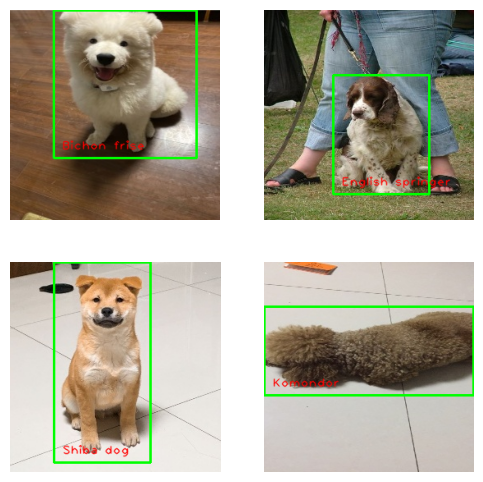

In [46]:
df = read_csv_with_array_columns('../data/dogs.csv', ['bboxes'])
idxs = np.random.permutation(len(df))[:4]
imgpaths = df['image'].iloc[idxs]
imgs = [Image.open(im) for im in imgpaths]
preds = [detector(im) for im in imgs]
annotations = [annotate_prediction(im, p) for im, p in zip(imgs, preds)]
show_images(annotations)

In [47]:
#| hide
import nbdev; nbdev.nbdev_export()